In [247]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# 0.1 Helpers: 

In [279]:
def print_df(df: pd.DataFrame):
    """printing data in table for easy readable in console output.

    Args:
        df (pd.DataFrame): any Dataframe for visualization
    """
    
    df.columns = df.columns.str.replace(' ', '')
    
    # Determine column width (including index)
    widths = [max(len("t"), 10)] + [max(len(str(x)), 20) for x in df.columns]

    # Center header (including “Index” as column index)
    header = " | ".join(str(col).center(width) for col, width in zip(["t"] + list(df.columns), widths))

    # Center values (including row index)
    rows = "\n".join(
    " | ".join(str(val).center(width) for val, width in zip([index] + list(row), widths))
    for index, row in zip(df.index, df.values)
    )

    # Merge and output
    print(header)
    print("-" * len(header))  # Dividing line
    print(rows)
    
    
def change_energy_units(
    values: list, 
    actual_unit: str, 
    target_unit: str):
    """Iterates through a list of values (int/float) and checks unit. If actual and target units differ it processes 
    all values into new unit and gives back new list as return value.

    Args:
        values (list): power or energy values
        actual_unit (str): actual unit of input values
        target_unit (str): target unit for values

    Returns:
        list: target values with intended target unit.
    """
    
    target_values = []
    
    # Permitted units
    kW_units = ['kW', 'kWh']
    MW_units = ['MW', 'MWh']
    GW_units = ['GW', 'GWh']
    
    for value in values: 
        if actual_unit in kW_units and target_unit in MW_units: 
            target_values.append(round((value / 1000),2))
        elif actual_unit in kW_units and target_unit in GW_units:
            target_values.append(round((value / 1000000),2))
        elif actual_unit in kW_units and target_unit in kW_units:
            target_values.append(round((value),2))
        elif actual_unit in MW_units and target_unit in GW_units:
            target_values.append(round((value / 1000),2))
        elif actual_unit in MW_units and target_unit in kW_units:
            target_values.append(round((value * 1000),2))
        elif actual_unit in MW_units and target_unit in MW_units:
            target_values.append(round((value),2))
        elif actual_unit in GW_units and target_unit in MW_units:
            target_values.append(round((value * 1000),2))
        elif actual_unit in GW_units and target_unit in kW_units:
            target_values.append(round((value * 1000000),2))
        elif actual_unit in GW_units and target_unit in GW_units:
            target_values.append(round((value),2))
        else: 
            raise KeyError("Unit not found. Check spelling or add unit in function.")
    
    # print(f"Calculation done for actual unit: {actual_unit} to target unit: {target_unit}")

    return target_values


def get_weeks_from_timestamp(
    timestamps: list
    ):
    """generates weeks from input-dates by cutting string and find out KW. Result is a list of Strings. 
    Useful for plotting diagrams based on weeks and not months.

    Args:
        timestamps (list): list of timestamps in format: ['YYYY-MM-DD/YYYY-MM-DD', ...] if weeks are set as granularity.

    Returns:
        list: list with strings of weeknumber [01, 02, 03, ...] based on startdate (suitbale for x axis)
    """
    weeks = []
    for timestamp in timestamps:
        start_str = timestamp.split('/')[0]  # note only the start value before the '/'
        
        # Convert start date to datetime
        start_date = datetime.strptime(start_str, "%Y-%m-%d")
        
        # Retrieve calendar week
        start_week = start_date.isocalendar()[1]
        weeks.append(start_week)
        
    return weeks


def get_months_from_timestamp(
    timestamps: list
    ):
    """Adjust the strings contained by default for the month, 
    by deleting the year and leaving only the month as a string.

    Args:
        timestamps (list): input timestamps in list ['YYYY-MM', ...]

    Returns:
        list: converted list with months as strings
    """
    months = []
    for timestamp in timestamps:
        year = timestamp[:4]
        months.append(timestamp.replace(f'{year}-', ''))

    return months

## 0.2 Load csv file: 

In [280]:
# Load DataFrame of CSV as input-data: 
def load_csv_results_in_df(
    input_path: str
    ):
    """Load output csv in dataframe.

    Args:
        input_path (str): path from which csv is loaded. 

    Returns:
        pd.DataFrame: csv data in dataframe as table type.
    """
    
    input_values_df = pd.read_csv(input_path, index_col=0)
    
    return input_values_df

# Example execution
# INPUT_PATH = "../data/output/output_time_series.csv"
# df = load_csv_results_in_df(input_path=INPUT_PATH)
# print_df(df=df)

# 1 Process Data: 

In [299]:
def add_timestamp_and_filter(
    input_df: pd.DataFrame, 
    start_date: str, 
    end_date: str, 
    time_column = 'date'
    ):
    """Insert Dates (YYYY-MM-DD) in DataFrame and filter after given start and end date.
    Assumption: 8784 values (366 days) beginning at 01.01.2025. If necessary needs to be 
    flexibilized.

    Args:
        df (pd.DataFrame, optional): Input Dataframe from results. Defaults to pd.DataFrame.
        start_date (str, optional): first date for filtering. Defaults to str.
        end_date (str, optional): end date for filtering. Defaults to str.
        time_column (str, optional): name of column with time steps. Default value 'date'.

    Returns:
        pd.DataFrame: added colomn with dates and filtered Dataframe after time span.
    """
    # Create List of dates and hours belonging to timestep:
    dates = list(pd.date_range('2025-01-01 00:00', periods=8784, freq='H'))
    input_df.insert(0, time_column, dates, allow_duplicates=False)
    input_df[time_column] = pd.to_datetime(input_df[time_column])
    
    # Delete blank spaces of colomn names:
    input_df.columns = input_df.columns.str.replace(' ', '')
    # print("Inserted date columns: /n", print_df(input_df)) # show assigned dates and hours
    # filtered df after time span:
    return input_df[(input_df[time_column] >= pd.Timestamp(start_date)) & (input_df[time_column] <= pd.Timestamp(end_date))]


def extract_price_data_to_dict(
    time_filtered_df: pd.DataFrame, 
    assets: tuple,
    key_gas_price: str,
    key_power_price: str
    ):
    """
    Reads certain columns associated with all relevant assets for the diagram from a DataFrame 
    and saves them in a dictionary.

    Parameters:
        time_series_df (pd.DataFrame): DataFrame, with all asset data summed up for certain granularity and time span.
        assets (tuple): A tuple with all assets that are to be displayed.
        type_of_energy (str): The type of energy that is relevant and can be read out with the assets.

    Returns:
        dict: A dictionary with the column names of the assets and the energy type according to the format 
        '{asset}.{type_of_energy}' as keys and the column values as an associated list.
    """
    # Generate the complete column names
    column_names = [key_gas_price, key_power_price] # convert input data for price names in list
    for asset in assets:   
        column_names.append(str(f"{asset}.co2")) # get keys of set assets in input data emitting co2 
        column_names.append(str(f"{asset}.power"))
        column_names.append(str(f"{asset}.gas"))
    print("column names: ", column_names)

    # Filter the desired columns:
    extracted_columns_dict = {col: list(time_filtered_df[col]) for col in column_names if col in time_filtered_df.columns}
    
    return extracted_columns_dict


def get_time_data_for_plot(
    time_filtered_df: pd.DataFrame, 
    granularity: str, 
    time_column='date'
): 
    """
    Generiert Zeitwerte für die x-Achse je nach gewählter Granularität:
    - Stundenwerte als Timestamps (immer enthalten)
    - Falls gewünscht: Monatszahlen, Kalenderwochen oder Tageswerte (Tag & Monat)

    Args:
        time_filtered_df (pd.DataFrame): Zeitlich gefiltertes DataFrame mit Zeitstempeln als Index.
        granularity (str): 'hour', 'day', 'week' oder 'month'.
        time_column (str, optional): Spalte mit Timestamps. Default: 'date'.

    Returns:
        tuple: (stündliche Timestamps, dict mit Werten für die x-Achse basierend auf Granularität)
    """

    # Sicherstellen, dass der Index als Datetime gesetzt ist
    time_filtered_df = time_filtered_df.copy()
    time_filtered_df[time_column] = pd.to_datetime(time_filtered_df[time_column])
    time_filtered_df.set_index(time_column, inplace=True)

    # Stündliche Timestamps (immer enthalten)
    hourly_timestamps = time_filtered_df.index.to_list()

    # X-Achsen-Ticks je nach Granularität
    first_occurrences_dict = {}
    
    if granularity == 'hour':
        for i, ts in enumerate(hourly_timestamps):
            hour = ts.strftime('%Y-%m-%d %H:%M')  # Extrahiere die Stunde und Minute (z. B. "14:30")
            first_occurrences_dict[hour] = i
    
    elif granularity == 'day':
        # ** Identifiziere den ersten Timestamp jedes Tages**
        for i, ts in enumerate(hourly_timestamps):
            day = ts.strftime('%d-%m')  # Extrahiere das Datum ohne Uhrzeit
            if day not in first_occurrences_dict:
                first_occurrences_dict[day] = i  # Speichere den Index des ersten Vorkommens
    
    elif granularity == 'week':
        # Kalenderwoche als Zahl extrahieren (1-53)
        for i, ts in enumerate(hourly_timestamps):
            week = f"KW {ts.strftime('%U')}"  # Extrahiere das Datum ohne Uhrzeit
            if week not in first_occurrences_dict:
                first_occurrences_dict[week] = i  # Speichere den Index des ersten Vorkommens
    
    elif granularity == 'month': 
        # Monat als Zahl extrahieren (1-12)
        for i, ts in enumerate(hourly_timestamps):
            month = ts.strftime('%m')  # Extrahiere das Datum ohne Uhrzeit
            if month not in first_occurrences_dict:
                first_occurrences_dict[month] = i  # Speichere den Index des ersten Vorkommens
    
    else: 
        raise ValueError(f"Granularity '{granularity}' not known. Please use 'hour', 'day', 'week', or 'month'.")
    
    return hourly_timestamps, first_occurrences_dict
    

In [300]:
# # Beispiel: Liste mit stündlichen Timestamps!
# result_hours = [
#     pd.Timestamp('2025-01-01 08:00:00'),
#     pd.Timestamp('2025-01-01 09:00:00'),
#     pd.Timestamp('2025-01-01 10:00:00'),
#     pd.Timestamp('2025-01-01 11:00:00'),
#     pd.Timestamp('2025-01-02 07:00:00'),
#     pd.Timestamp('2025-01-02 08:00:00'),
#     pd.Timestamp('2025-01-02 09:00:00'),
#     pd.Timestamp('2025-01-03 06:00:00'),
#     pd.Timestamp('2025-01-03 07:00:00'),
# ]

# # Dummy-Werte für die y-Achse
# y_values = list(range(len(result_hours)))

# # **1️⃣ Identifiziere den ersten Timestamp jedes Tages mit Tag-Monat**
# first_occurrences = {}
# for i, ts in enumerate(result_hours):
#     day = ts.strftime('%d-%m')  # Nur Tag und Monat extrahieren
#     if day not in first_occurrences:
#         first_occurrences[day] = i  # Speichere den Index des ersten Vorkommens

# # **2️⃣ Plot der stündlichen Werte**
# plt.plot(result_hours, y_values, marker='o')

# # **3️⃣ Setze x-Ticks nur für den ersten Timestamp jedes Tages**
# plt.xticks(
#     [result_hours[i] for i in first_occurrences.values()],  # Die x-Werte (erste Zeit pro Tag)
#     [day for day in first_occurrences.keys()],  # Die Label (dd-mm)
#     rotation=45  # Labels um 45° drehen für bessere Lesbarkeit
# )

# # **4️⃣ Achsenbeschriftungen**
# plt.xlabel("Tagesstart (Tag-Monat)")
# plt.ylabel("Werte")
# plt.title("Zeitreihe mit nur dem ersten Wert pro Tag (Tag-Monat) auf der x-Achse")

# 2 Calculate CSS: 

In [301]:
def calculate_css(
    price_dict: dict,
    key_gas_price: str,
    key_electr_price: str,
    P_co2: float,
    eta_el: float,
    alpha: float,
    beta: float
): 
    """_summary_

    Args:
        price_dict (dict): _description_
        key_gas_price (str): _description_
        key_electr_price (str): _description_
        P_co2 (float): _description_
        eta_el (float): _description_
        alpha (float): _description_
        beta (float): _description_

    Raises:
        KeyError: _description_

    Returns:
        _type_: _description_
    """
    if key_gas_price not in price_dict or key_electr_price not in price_dict:
        raise KeyError(f"Keys {key_gas_price} oder {key_electr_price} fehlen im Dictionary")
    
    # print("P_co2: ", P_co2)
    # print("eta_el: ", eta_el)
    # print("alpha: ", alpha)
    # print("beta: ", beta)
    
    css_values = []
    for P_power, P_gas in zip(price_dict[key_electr_price], price_dict[key_gas_price]): 
        css = P_power - (1/eta_el) * (alpha * P_gas + beta * P_co2) # Formel Berechnung CSS
        css_values.append(round(css, 2))
    
    # print("CSS: ", css_values)
    # print("Anzahl CSS werte", len(css_values))
    
    return css_values    

# 3 Plot Cost data

In [302]:
def plot_css(
    y_values: list,
    x_values: list,
    granularity: str,
    x_axis_occurencies: dict, 
    title_size: str,
    fontsize: str, 
    color_of_line: tuple, 
    other_cost_data: dict
): 
    
    fig, ax = plt.subplots(figsize=(16, 9), facecolor="white")
    ax.plot(x_values, y_values, marker=None, linestyle='-', label="CSS", color=color_of_line)
    
    # **2️⃣ Setze x-Ticks nur für bestimmte Granularitäten**
    #     # **2️⃣ Setze x-Ticks nur für bestimmte Granularitäten**
    # ax.set_xticks([x_values[v['index']] for v in x_axis_occurencies.values()])
    # ax.set_xticklabels(
    #     [
    #         k if (v['full_time'].endswith("00:00") or granularity != 'hour') else ""  
    #         for k, v in x_axis_occurencies.items()
    #     ],
    #     rotation=45
    #     )
    
    if granularity == 'hour': 
        ax.set_xticks([x_values[i] for i in x_axis_occurencies.values()])
        # Konvertiere die vollständigen Datumsangaben in nur "HH:MM" für die Achsenbeschriftung
        ax.set_xticklabels(
            [key[-5:] for key in x_axis_occurencies.keys()],  # Schneidet nur "HH:MM" aus dem String
            rotation=45  # Labels drehen für bessere Lesbarkeit
            )
    else: 
        ax.set_xticks(
        [x_values[i] for i in x_axis_occurencies.values()],  # X-Werte reduzieren
        [tick for tick in x_axis_occurencies.keys()],  # Labels entsprechend Granularität setzen
        rotation=45  # Labels drehen für bessere Lesbarkeit
        )
    
    ax.set_xlabel(f"Time in {granularity}s", fontsize=fontsize, fontweight='bold')
    ax.set_ylabel("Clean Spark Spread in €/MWh", fontsize=fontsize, fontweight='bold')
    ax.set_title("Clean Spark Spread of scenario UE24", fontsize=title_size, fontweight='bold', y=1.1)
    
    # **4️⃣ Gitternetz einfügen**
    ax.grid(True, color='gray', linestyle='--', linewidth=0.5, zorder=1)
    ax.tick_params(axis='x', labelsize=fontsize) 
    ax.tick_params(axis='y', labelsize=fontsize)

    # **5️⃣ Legende oberhalb des Diagramms positionieren**
    ax.legend(
        loc="lower center",           # position of legend
        bbox_to_anchor=(0.5, 1.0, 0, 0),   # anchor point (x=0.5 for central, y=1.0 for above)
        ncol=3,                      # amount of columns in legend
        frameon=True,                # Frame around legend
        fontsize=fontsize,
        title_fontsize=fontsize
        )

    # **6️⃣ Diagramm anzeigen**
    plt.show()
    
    return fig

# Main script: 

## Input values: 

In [307]:
# 1 General Definition of variables:

# Fixe Werte: 

# Beispielwerte aus csv: 

# P_electr = 52.77 # €/MWh
# gas_price = 39.345 # € / MWh

# CSS = (P_electr - (1/eta_el) * (alpha * gas_price + beta * P_co2)) # € / MWh

# print("CSS: ", CSS)

#############################

# 1 Definition Pathes, file and folder names for diagram:
filename = 'share_of_assets_colortest_power_lsw.png'
output_folder_name = 'share_of_assets'
colors_filename = "assigned_colors.json"
INPUT_PATH = '../data/output/output_time_series.csv'
OUTPUT_PATH = '../data/postprocessing/' + output_folder_name
storage_diagram = True # true if you want storages values in plot

# 2 time data: 
start_time = "2025-07-01 00:00" 
end_time = "2025-07-05 00:00"
granularity = 'day'

# 3 asset data: 
my_assets = ('chp_1', 'chp_2')
key_gas_price = 'gas_price'
key_power_price = 'power_price'

# 4 Constant price parameter: 
P_co2 = 76 # € / t
eta_el = 0.41
alpha = 1.107
beta = 0.2016

# 5 Plot constants: 
title_size = 18
fontsize = 16
color_of_line = (0.09019607843, 0.2431372549, 0.431372549, 1.0)

# Zeit dynamisch: 

# funktion: 
#     - Daten um Datetime ergänzen √
#     - filtern nach Zeitraum und granularity ohne Summe √
#     - Ziehen der Daten für CSS in dict √
#     - Laden Zeitdaten in Liste √
#     - Berechnung mit dict von CSS und speichern in liste (y-Achse) √
#     - plot von gasprice, co2-price, powerprice übers jahr als Linie
#     - plot als Liniendiagramm von CSS
    
    
# - Zeiträume in Datum und Stunde (timestamp) ohne aufsummieren



column names:  ['gas_price', 'power_price', 'chp_1.co2', 'chp_1.power', 'chp_1.gas', 'chp_2.co2', 'chp_2.power', 'chp_2.gas']
price dict:  {'gas_price': [31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 31.776, 32.492, 32.492, 32.492, 32.492, 32.492, 32.492, 32.492, 32.492, 32.492, 32.492, 32.492, 32.492, 32.492, 32.492, 32.492, 32.492, 32.492, 32.492, 32.492, 32.492, 32.492, 32.492, 32.492, 32.492, 32.492, 32.492], 'power_price': [107.54, 107.54, 81.16, 80.35, 80.37, 87.51, 72.98, 48

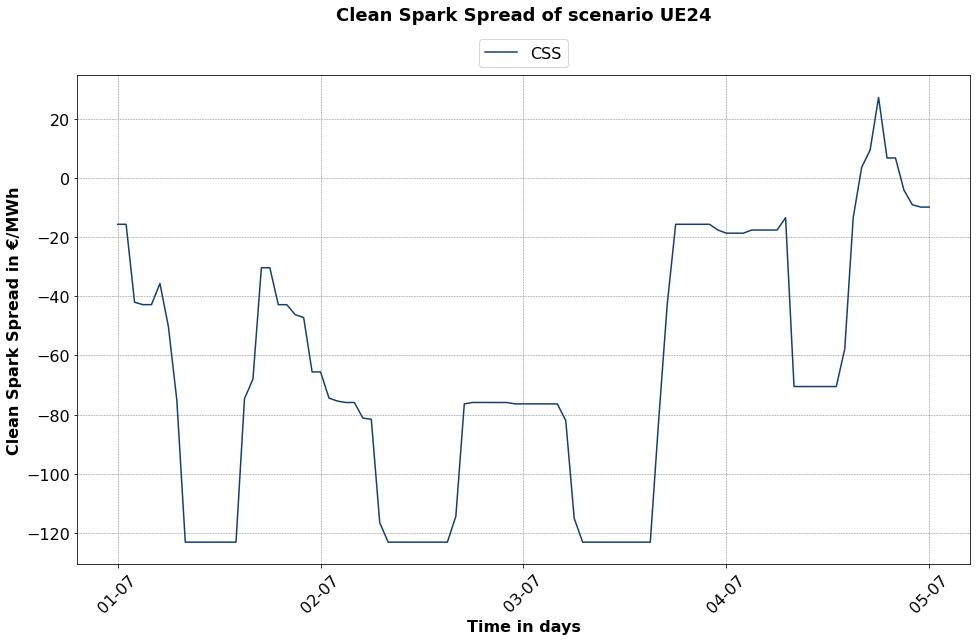

In [ ]:
if __name__ == "__main__":
    input_csv = load_csv_results_in_df(input_path=INPUT_PATH)
    df_with_time = add_timestamp_and_filter(
    input_df = input_csv, 
    start_date = start_time, 
    end_date = end_time, 
    time_column = 'date'
    )
    # print_df(df=df_with_time)
    
    price_dict = extract_price_data_to_dict(
    time_filtered_df = df_with_time, 
    assets = my_assets,
    key_gas_price = key_gas_price,
    key_power_price = key_power_price
    )
    print("price dict: ", price_dict)
    
    hourly_timestamps, occurencies_dict = get_time_data_for_plot(
        time_filtered_df=df_with_time,
        granularity=granularity
    )
    
    print("hourly_timestamps: ", hourly_timestamps)
    print("occurencies_dict: ", occurencies_dict)
    
    css_values = calculate_css(
    price_dict = price_dict,
    key_gas_price = key_gas_price,
    key_electr_price = key_power_price,
    P_co2=P_co2,
    eta_el = eta_el,
    alpha = alpha,
    beta = beta)
    
    print("css_values: ", css_values)
    
    fig = plot_css(
    y_values = css_values,
    x_values = hourly_timestamps,
    granularity = granularity,
    x_axis_occurencies =occurencies_dict,
    title_size=title_size,
    fontsize = fontsize, 
    color_of_line = color_of_line,
    other_cost_data = price_dict
    )
     